## Computational Homework 7
by Aleena and Kriti

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre

In [2]:
class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=800.000, C0=2.470795*10**(-2), nx=12,mpi=138.0,A=-0.1544435):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
            mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat

In [3]:
pot = OBEpot()

In [4]:
def kronekar (i,k):
    if (i==k):
        return 1
    else:
        return 0
    
def trns(np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gauss-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((N+1),dtype=np.double)
      pweight=np.empty((N+1),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight

In [5]:
def matA (i,k,V_ik,q,p,w,p_max,mu=938.92):
    A=0
    if (k!=N):
        return kronekar(i,k)-2*mu*V_ik*(p[k]**2)*w[k]/(q**2-p[k]**2)
    elif(k==N):
        for m in range(N):
               A+=2*mu*V_ik*q**2*w[m]/(q**2-p[m]**2)
               
        return(kronekar(i,k)+A-mu*q*V_ik*np.log(p_max+q/(p_max-q))+1j*np.pi*mu*q*V_ik)       
        

In [6]:
pot=OBEpot(nx=24,mpi=138.0)
print(pot.v)

<bound method OBEpot.v of <__main__.OBEpot object at 0x000002617EE65EE0>>


In [7]:
N=30
A=np.zeros((N+1,N+1),dtype='complex')
V=np.zeros((N+1,N+1))
p_grid,w=trns(20,10,1.0,5.0,35.0)
q=1
p_grid=np.concatenate((p_grid,[q]),axis=None)
for i in range(N+1):
          for j in range(N+1): 
            V[i][j]=pot.v(p_grid[i],p_grid[j],0)


for i in range(0,len(p_grid)):
    for k in range(0,len(p_grid)):
        A[i][k]=matA(i,k,V[i][k],q,p_grid,w,20)
        
        


In [8]:
t=np.linalg.inv(A)@V
print(t[N][N])

(-0.0001666372635606081-0.0001384414671008402j)


In [9]:
S=1-2j*np.pi*938.92*q*t[N][N]
print(np.linalg.norm(S))

1.0000000000000278


Since S is coming out to be one which is required

In [10]:
N_grid=np.linspace(10,40,7).astype(int)
Pmax_grid=np.linspace(10,30,11)

In [18]:
stab_mat=np.zeros((len(N_grid),len(Pmax_grid)))
for n in range(len(N_grid)):
    for m in range(len(Pmax_grid)):
        N=N_grid[n]
        A=np.zeros((N_grid[n]+1,N_grid[n]+1),dtype='complex')
        V=np.zeros((N_grid[n]+1,N_grid[n]+1))
        
        p_grid,w=trns(int(np.ceil(2*N_grid[n]/3)),int(N_grid[n]/3),1.0,5.0,Pmax_grid[m])
        q=np.sqrt(2*938.92*1)  ## we have fixed a q accordind to the conndition E=1Mev
        
        p_grid=np.concatenate((p_grid,[q]),axis=None)
        for i in range(N_grid[n]+1):
            for j in range(N_grid[n]+1):
                V[i][j]=pot.v(p_grid[i],p_grid[j],0)


        for i in range(0,len(p_grid)):
            for k in range(0,len(p_grid)):
                A[i][k]=matA(i,k,V[i][k],q,p_grid,w,Pmax_grid[m])
        t=np.linalg.inv(A)@V
        S=1-2j*np.pi*938.92*q*t[N_grid[n]][N_grid[n]]
        stab_mat[n][m]=np.linalg.norm(S)
        
    

In [19]:
print(p_grid)

[2.39138702e-03 1.26430129e-02 3.12627706e-02 5.85613641e-02
 9.49922319e-02 1.41165742e-01 1.97863884e-01 2.66057921e-01
 3.46928718e-01 4.41888693e-01 5.52603294e-01 6.81008221e-01
 8.29315851e-01 1.00000000e+00 1.19574165e+00 1.41930883e+00
 1.67333139e+00 1.95991649e+00 2.28003864e+00 2.63263884e+00
 3.01340441e+00 3.41330785e+00 3.81719590e+00 4.20303266e+00
 4.54268635e+00 4.80510401e+00 4.96201035e+00 5.19771182e+00
 6.03002001e+00 7.48027387e+00 9.47063326e+00 1.18938406e+01
 1.46192711e+01 1.75000000e+01 2.03807289e+01 2.31061594e+01
 2.55293667e+01 2.75197261e+01 2.89699800e+01 2.98022882e+01
 2.00000000e+00]


In [13]:
### pmax --> infty
def matA1 (i,k,V_ik,q,p,w,p_max,mu=938.92):
    A=0
    if (k!=N):
        return kronekar(i,k)-2*mu*V_ik*(p[k]**2)*w[k]/(q**2-p[k]**2)
    elif(k==N):
        for m in range(N):
               A+=2*mu*V_ik*q**2*w[m]/(q**2-p[m]**2)
               
        return(kronekar(i,k)+A+1j*np.pi*mu*q*V_ik)  

In [14]:
N=30
A=np.zeros((N+1,N+1),dtype='complex')
A1=np.zeros((N+1,N+1),dtype='complex')
V=np.zeros((N+1,N+1))
pmax_grid=np.linspace(20,500,25)
pinf=np.zeros(len(pmax_grid))
pfinite=np.zeros(len(pmax_grid))
for m in range(len(pmax_grid)):
    p_grid,w=trns(20,10,1.0,5.0,pmax_grid[m])
    q=10
    p_grid=np.concatenate((p_grid,[q]),axis=None)
    for i in range(N+1):
        for j in range(N+1): 
            V[i][j]=pot.v(p_grid[i],p_grid[j],0)   ## l=0


    for i in range(0,len(p_grid)):
        for k in range(0,len(p_grid)):
            A[i][k]=matA(i,k,V[i][k],q,p_grid,w,pmax_grid[m])
            A1[i][k]=matA1(i,k,V[i][k],q,p_grid,w,pmax_grid[m])

    t=np.linalg.inv(A)@V
    t1=np.linalg.inv(A1)@V
    S1=1-2j*np.pi*938.92*q*t1[N][N]                  
    S=1-2j*np.pi*938.92*q*t[N][N]
    pinf[m]=1.-np.linalg.norm(S1)
    pfinite[m]=1.-np.linalg.norm(S)                  



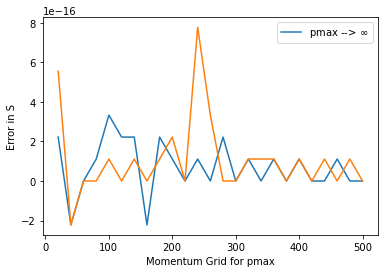

In [21]:
plt.xlabel('Momentum Grid for pmax')
plt.ylabel('Error in S')
plt.plot(pmax_grid,pinf,label = 'pmax --> $\infty$')
plt.plot(pmax_grid,pfinite)
plt.legend()

we expect the difference between the two plots to reduce as we increase pmax which we observe in our plot. Also the initial value S for the A matrix where  pmax tend to $\infty$ is less than the the value of S where Pmax doesn't tend to $\infty$ as expected. as for the trend that we observe we couldn't make much sense of it

In [28]:
## Plotting the phase shift
Earr = np.linspace(0,200,100) #MeV
qarr = np.sqrt(2*938.92*Earr)
dlist = np.zeros(len(Earr))#dtype='complex')

N=30
for m in range(len(Earr)):
    A=np.zeros((N+1,N+1),dtype='complex')
    V=np.zeros((N+1,N+1))
    p_grid,w=trns(20,10,1.0,5.0,35.0)


    p_grid=np.concatenate((p_grid,[qarr[m]]),axis=None)
    for i in range(N+1):
              for j in range(N+1): 
                V[i][j]=pot.v(p_grid[i],p_grid[j],0)


    for i in range(0,len(p_grid)):
        for k in range(0,len(p_grid)):
            A[i][k]=matA(i,k,V[i][k],qarr[m],p_grid,w,20)

    t=np.linalg.inv(A)@V
    S=1-2j*np.pi*938.92*qarr[m]*t[N][N]
    delta = 0.5*np.arctan2(np.imag(S),np.real(S))
    dlist[m] = delta


Text(0, 0.5, '$\\delta (E)$')

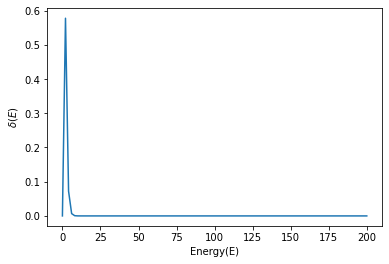

In [30]:
plt.plot(Earr,dlist)
plt.xlabel('Energy(E)')
plt.ylabel('$\delta (E)$')

In [36]:
from scipy.special import eval_legendre

q1 = np.sqrt(2*938.92*10)
tarr = np.zeros((7),dtype = 'complex')

for m in range(7):
    A=np.zeros((N+1,N+1),dtype='complex')
    V=np.zeros((N+1,N+1))
    p_grid,w=trns(20,10,1.0,5.0,35.0)


    p_grid=np.concatenate((p_grid,[q1]),axis=None)
    for i in range(N+1):
        for j in range(N+1): 
            V[i][j]=pot.v(p_grid[i],p_grid[j],m)


    for i in range(0,len(p_grid)):
        for k in range(0,len(p_grid)):
            A[i][k]=matA(i,k,V[i][k],q1,p_grid,w,20)

    t=np.linalg.inv(A)@V
    tarr[m] = t[N][N]

sumlist = []
carr = np.linspace(-1,1,20)
for n in range(7):
    sum = np.zeros(len(carr))
    for l in range(n):
        for l_ in range(n):
            
            sum += np.real((2*l+1)*(2*l_+1)*tarr[l]*np.conjugate(tarr[l_])*eval_legendre(l,carr)*eval_legendre(l_,carr))
    sumlist.append(sum)
            


Text(0, 0.5, 'd$\\sigma$/d(cos($\\theta$))')

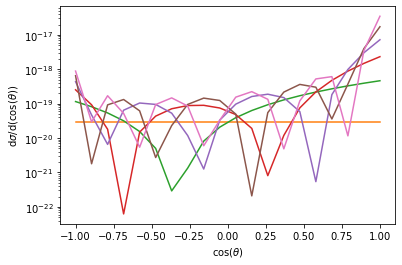

In [44]:

for i in range(7):
    
    plt.semilogy(carr,sumlist[i])
    
plt.xlabel(r'cos($\theta$)')
plt.ylabel(r'd$\sigma$/d(cos($\theta$))')